In [18]:
import os
import sqlite3
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

hosts = ["zeit.de", "cnn.com", "faz.net", "merkur.de", "n-tv.de", "sueddeutsche.de", "telegraph.co.uk", "theguardian.com", "thehindu.com", "zeit.de", "amazon.de", "depot-online.de", "douglas.de", "hm.com", "nike.com", "samsung.com", "saturn.de", "sephora.de", "uniqlo.com", "zalando.de"]

def extractDomains(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        harData = json.load(file)
        entries = harData.get('log', {}).get('entries', [])
        domains = []

        for entry in entries:
            response = entry.get('response', {})
            responseHeaders = response.get('headers', [])

            for header in responseHeaders:
                if header['name'].lower() == 'set-cookie':
                    cookies = header['value']

                    match = re.search(r'Domain=([^;]+)', cookies)
                    domain = match.group(1) if match else None
                    

                    if domain and domain not in hosts:
                        if domain.startswith('.'):
                            domain = domain[1:]
                            
                        domains.append(domain)
        filtered_domains = [domain for domain in domains if domain not in hosts]
        return filtered_domains

def processFolder(folder_path):
    all_domains = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.har'):
            path = os.path.join(folder_path, filename)
            domains = extractDomains(path)
            all_domains.extend(domains)

    return all_domains

paths = ['../archives/news/desktop/', '../archives/news/mobile/']

with sqlite3.connect('third_party_analysis.db') as dbConn:
    dbCursor = dbConn.cursor()

    dbCursor.execute('''
        CREATE TABLE IF NOT EXISTS cookie_counts (
            domain TEXT PRIMARY KEY,
            count INTEGER
        )
    ''')
    allDomains = []
    
    for folder_path in paths:
        allDomains += processFolder(folder_path)

    domainCounter = Counter(allDomains)

    for domain, count in domainCounter.items():
        dbCursor.execute('INSERT OR REPLACE INTO cookie_counts VALUES (?, ?)', (domain, count))


In [19]:
dbConn = sqlite3.connect('third_party_analysis.db')
dbCursor = dbConn.cursor()

dbCursor.execute('SELECT domain, count FROM cookie_counts ORDER BY count DESC')
sortedRecords = dbCursor.fetchall()

print("Count\tThird party domain")
print("------------------------------------")
for domain, count in sortedRecords:
    print(f"{count}\t{domain}")

dbConn.close()

Count	Third party domain
------------------------------------
307	adnxs.com
272	rubiconproject.com
195	xplosion.de
188	casalemedia.com
165	taboola.com
164	id5-sync.com
80	cxense.com
76	omnitagjs.com
75	yieldlab.net
71	amazon-adsystem.com
70	rfihub.com
64	yahoo.com
54	openx.net
47	seedtag.com
42	ads.stickyadstv.com
41	demdex.net
40	prod.svc.y6b.de
34	eyeota.net
28	youtube.com
27	contextweb.com
27	the-ozone-project.com
26	analytics.yahoo.com
26	bidr.io
24	everesttech.net
24	bild.de
24	d.adup-tech.com
22	twitter.com
19	t.co
18	linkedin.com
18	rezync.com
18	semasio.net
17	lijit.com
17	zemanta.com
16	3lift.com
16	dpm.demdex.net
16	360yield.com
15	tagger.opecloud.com
15	outbrain.com
14	pinterest.com
14	turn.com
14	tapad.com
14	df-srv.de
14	aniview.com
13	w55c.net
13	connectad.io
12	creativecdn.com
9	teads.tv
9	dianomi.com
9	google.com
9	google.de
8	undertone.com
8	exelator.com
8	crwdcntrl.net
8	audrte.com
8	f11-ads.com
7	bluekai.com
7	tiktok.com
6	agkn.com
6	fwmrm.net
6	sharethrough.com
6	me

**Visualization**

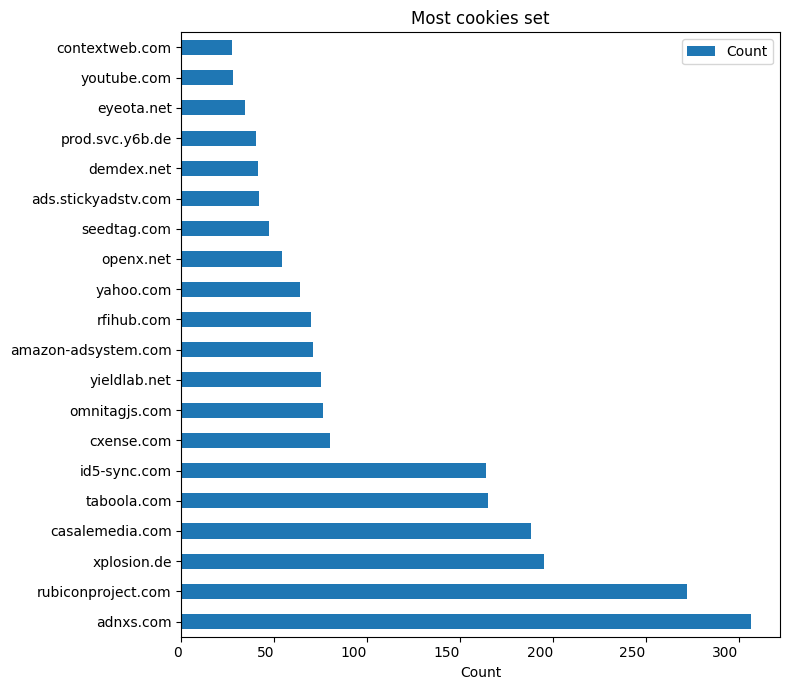

In [20]:
df = pd.DataFrame(sortedRecords, columns=['Domain', 'Count'])

df_top20 = df.head(20)

df_top20.plot(kind='barh', x='Domain', y='Count', figsize=(8, 7))

plt.title('Most cookies set')
plt.xlabel('Count')
plt.ylabel('')

plt.xticks( fontsize='medium', ha='right')

plt.tight_layout()
plt.show()